<a href="https://colab.research.google.com/github/p-dros/analysis/blob/main/timeseries/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette("Blues")
plt.style.use('ggplot')

# Data

In [ ]:
df = pd.read_csv('data.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)
df

In [ ]:
df.rename(columns={"Zone 2  Power Consumption": "Zone 2 Power Consumption", "Zone 3  Power Consumption": "Zone 3 Power Consumption"}, inplace=True)

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.hist(bins=50, figsize=(14,8))
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

axes[0].plot(df['Zone 1 Power Consumption'],color='skyblue')
axes[0].set_title('Zone 1')

axes[1].plot(df['Zone 2 Power Consumption'],color='mediumseagreen')
axes[1].set_title('Zone 2')

axes[2].plot(df.index, df['Zone 3 Power Consumption'],color='blueviolet')
axes[2].set_title('Zone 3')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['All Zones Power Consumption'] = df['Zone 1 Power Consumption']+df['Zone 2 Power Consumption']+df['Zone 3 Power Consumption']
    return df

df = create_features(df)
df

In [ ]:
targets = df[['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption', 'All Zones Power Consumption']]
correlation_matrix = targets.corr()
print(correlation_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Power Consumption Zones')
plt.show()

In [ ]:
columns_to_exclude = ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption', 'hour', 'dayofweek', 'month']

corr_matrix = df.drop(columns=columns_to_exclude).corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x='hour', y='All Zones Power Consumption', palette='Blues', showfliers=False)
ax.set_title('Power Consumption by Hour')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x='hour', y='Temperature', palette='Reds', showfliers=False)
ax.set_title('Temperature by Hour')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x='hour', y='Humidity', palette='Greens', showfliers=False)
ax.set_title('Humidity Consumption by Hour')
plt.show()

Other x values

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='month', y='All Zones Power Consumption', palette='Greens')
ax.set_title('Power Consumption by Month')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='dayofweek', y='All Zones Power Consumption', palette='Reds')
ax.set_title('PowerConsumption by day of week')
plt.show()

# Data split

In [ ]:
train = df.iloc[:int(len(df) * 0.7)]
test_valid = df.iloc[int(len(df) * 0.7):]

test = test_valid.iloc[:len(test_valid) // 2]
valid = test_valid.iloc[len(test_valid) // 2:]

print(f"Train set length: {len(train)}")
print(f"Test set length: {len(test)}")
print(f"Validation set length: {len(valid)}")

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='All Zones Power Consumption', label='Training Set', title='Data Split',color='blueviolet')
test.plot(ax=ax, y='All Zones Power Consumption', label='Test Set', color='mediumseagreen')
valid.plot(ax=ax, y='All Zones Power Consumption', label='Validation Set', color='skyblue')
ax.legend(['Training Set', 'Test Set', 'Validation Set'])
plt.show()


# Building models

In [ ]:
!pip install fastapi python-multipart uvicorn
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 936.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.4 MB/s eta

In [ ]:
from pycaret.regression import *

In [ ]:
train1 = train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','hour','month', 'Zone 1 Power Consumption']]
test1 = test[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','hour','month', 'Zone 1 Power Consumption']]
valid1 = valid[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','hour','month', 'Zone 1 Power Consumption']]

In [ ]:
s = setup(data = train1, test_data = test1,
          target='Zone 1 Power Consumption',
          preprocess = True,
          fold_strategy='timeseries',
          fold_shuffle=False,
          data_split_shuffle=False)

In [ ]:
best = compare_models(sort = 'MSE', include=['et', 'lightgbm', 'xgboost', 'knn', 'rf', 'lr'])

In [ ]:
evaluate_model(best)

In [ ]:
models_data = models()
models_data

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
from io import StringIO

data_str = """
Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,2200.3286,9666241.5193,2917.6552,0.8000,0.0901,0.0670,3.5770
rf,2237.0855,9974925.9049,2993.6080,0.7937,0.0928,0.0682,8.8730
lightgbm,2233.9546,10024416.4583,2970.2072,0.7930,0.0920,0.0683,0.8660
gbr,2330.0356,10326699.7158,3026.3999,0.7865,0.0947,0.0715,2.5010
xgboost,2352.4514,11001765.9000,3135.7708,0.7727,0.0970,0.0717,0.2650
dt,2586.2081,12904634.6017,3482.2999,0.7316,0.1101,0.0793,0.1460
ada,2839.6595,13718683.8322,3531.0144,0.7163,0.1096,0.0860,1.0780
knn,2913.4496,15806540.1000,3846.1332,0.6716,0.1193,0.0893,0.0800
en,3573.7177,21160438.7000,4523.9361,0.5603,0.1424,0.1107,0.0400
br,3576.3562,21249955.1000,4533.0109,0.5585,0.1428,0.1106,0.0550
lasso,3576.7313,21257233.7000,4533.9412,0.5583,0.1429,0.1106,0.0380
llar,3576.7320,21257240.6000,4533.9419,0.5583,0.1429,0.1106,0.0570
ridge,3576.8781,21259843.1000,4534.2367,0.5583,0.1429,0.1106,0.0410
lr,3576.8836,21259937.9000,4534.2486,0.5583,0.1429,0.1106,0.5490
lar,3577.5561,21345149.6000,4542.3927,0.5564,0.1435,0.1106,0.0590
huber,4522.9937,33927121.4958,5669.4865,0.2923,0.1784,0.1443,0.2370
par,5060.9640,41904302.2852,6219.9617,0.1392,0.2080,0.1581,0.0890
omp,5729.6861,51448460.0000,7147.6165,-0.0816,0.2153,0.1744,0.0590
dummy,6088.5263,53013313.6000,7254.6918,-0.1158,0.2201,0.1867,0.0300
"""

models_data = pd.read_csv(StringIO(data_str))
models_data.head()
models_data = models_data.iloc[[0, 1, 2, 4, 7, 13], :]
models_data

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,et,2200.3286,9.666242e+06,2917.6552,0.8000,0.0901,0.0670,3.577
1,rf,2237.0855,9.974926e+06,2993.6080,0.7937,0.0928,0.0682,8.873
2,lightgbm,2233.9546,1.002442e+07,2970.2072,0.7930,0.0920,0.0683,0.866
4,xgboost,2352.4514,1.100177e+07,3135.7708,0.7727,0.0970,0.0717,0.265
7,knn,2913.4496,1.580654e+07,3846.1332,0.6716,0.1193,0.0893,0.080
13,lr,3576.8836,2.125994e+07,4534.2486,0.5583,0.1429,0.1106,0.549


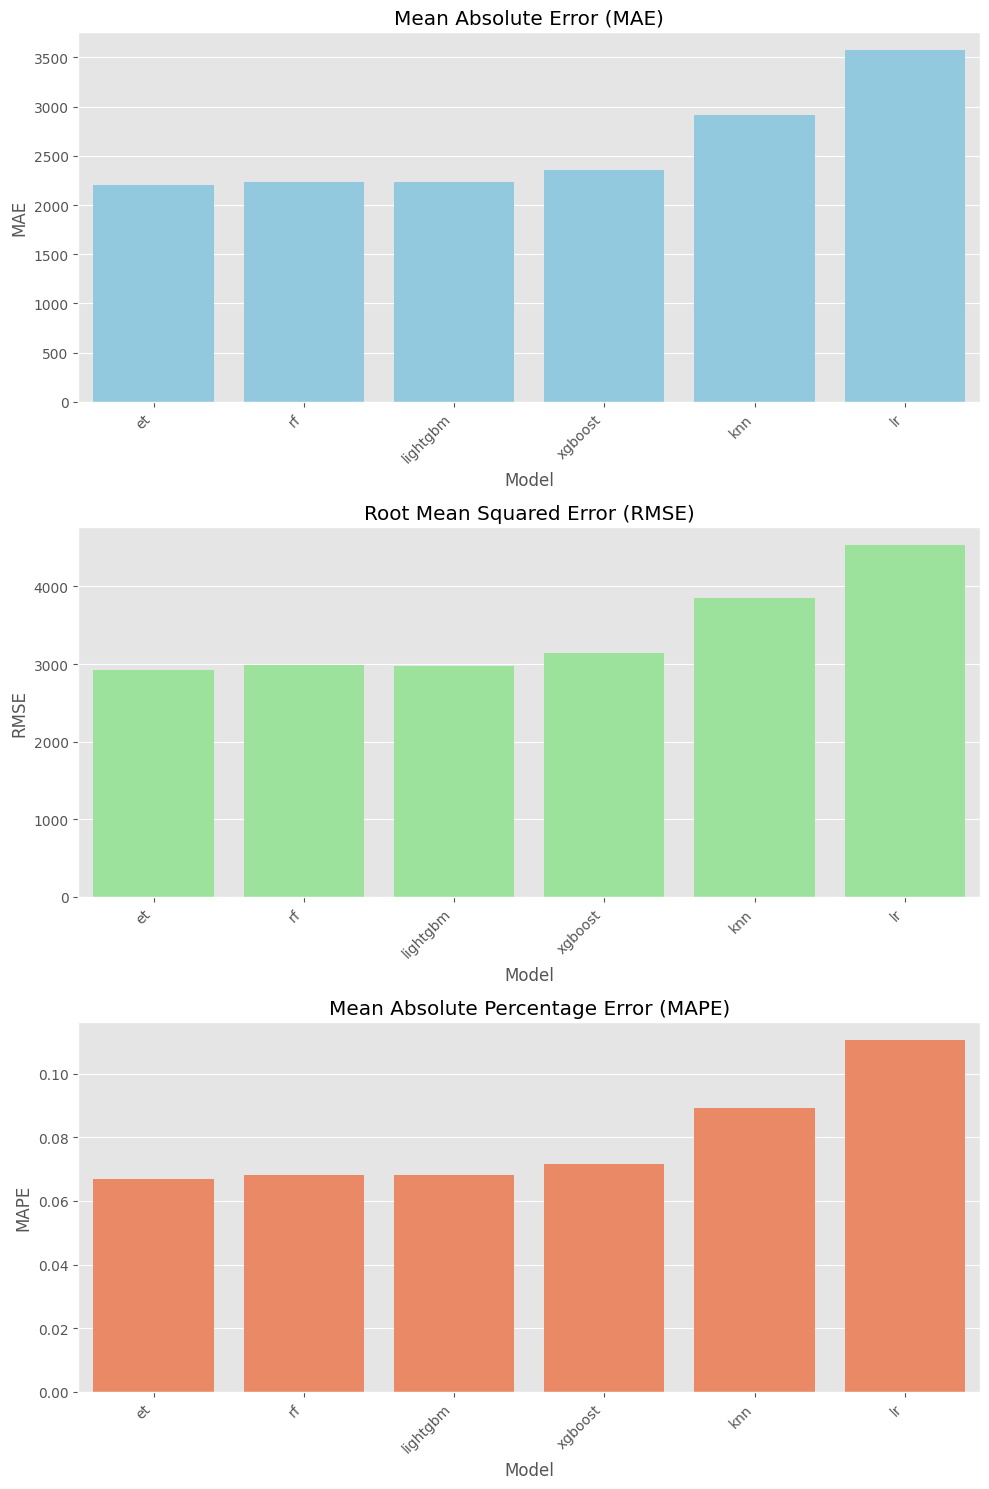

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

models_data[['MAE', 'MSE', 'RMSE', 'R2', 'RMSLE', 'MAPE', 'TT (Sec)']] = models_data[['MAE', 'MSE', 'RMSE', 'R2', 'RMSLE', 'MAPE', 'TT (Sec)']].apply(pd.to_numeric)
models_data = models_data.set_index('Model')

# Set the model names as the index for better visualization

# Plotting MAE, RMSE, and MAPE for all models
fig, axes = plt.subplots(nrows=3, figsize=(10, 15))
sns.barplot(x=models_data.index, y=models_data['MAE'], ax=axes[0], color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)')

sns.barplot(x=models_data.index, y=models_data['RMSE'], ax=axes[1], color='lightgreen')
axes[1].set_title('Root Mean Squared Error (RMSE)')

sns.barplot(x=models_data.index, y=models_data['MAPE'], ax=axes[2], color='coral')
axes[2].set_title('Mean Absolute Percentage Error (MAPE)')

# Rotate x-axis labels for better visibility
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

predictions = predict_model(best, data=test1)

fig = px.line(predictions, x=predictions.index, y=["Zone 1 Power Consumption", "prediction_label"])
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3117.1063,14511766.0156,3809.4312,0.6688,0.1181,0.0972


In [ ]:
print(best)

ExtraTreesRegressor(n_jobs=-1, random_state=6290)


In [ ]:
traintest1 = pd.concat([train1,test1])

s = setup(data = traintest1, test_data = valid1,
          target='Zone 1 Power Consumption',
          fold_strategy='timeseries',
          fold_shuffle=False,
          data_split_shuffle=False)

,Description,Value
0,Session id,8071
1,Target,Zone 1 Power Consumption
2,Target type,Regression
3,Original data shape,"(52416, 8)"
4,Transformed data shape,"(52416, 8)"
5,Transformed train set shape,"(44553, 8)"
6,Transformed test set shape,"(7863, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [ ]:
model_name = "et"
extra_model = create_model('et', n_jobs=-1, random_state=7681)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1595.4058,4446135.0310,2108.5860,0.9065,0.0737,0.0543
1,1441.3194,3764525.8548,1940.2386,0.9191,0.0630,0.0472
2,1795.6443,6034152.8066,2456.4513,0.8566,0.0818,0.0600
3,1491.6731,3719851.0443,1928.6915,0.9131,0.0646,0.0493
4,3885.5748,28719895.1966,5359.0946,0.4407,0.1653,0.1106
5,3259.3173,17837702.5501,4223.4704,0.6440,0.1232,0.0987
6,2435.9433,8582490.4133,2929.5888,0.8222,0.0796,0.0645
7,2350.7077,9351361.1702,3057.9995,0.8139,0.0914,0.0724
8,3028.6930,13492605.9813,3673.2283,0.6803,0.1094,0.0877


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
custom_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

tuned_extra_model = tune_model(extra_model, n_iter=5, custom_grid=custom_grid)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1844.6884,5724830.0913,2392.6617,0.8796,0.0826,0.0629
1,1460.5254,3765559.5680,1940.5050,0.9191,0.0640,0.0485
2,1756.7054,5915383.7977,2432.1562,0.8594,0.0783,0.0574
3,1676.3786,4815206.1518,2194.3578,0.8875,0.0757,0.0571
4,3813.3498,27140934.3690,5209.6962,0.4715,0.1605,0.1091
5,3230.0794,15175102.1158,3895.5233,0.6972,0.1185,0.0999
6,2595.8696,9959982.6020,3155.9440,0.7936,0.0851,0.0683
7,2228.4572,8474826.7531,2911.1556,0.8314,0.0882,0.0687
8,2549.7630,9782657.1152,3127.7240,0.7682,0.0897,0.0730


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [ ]:
tuned_extra_model

ExtraTreesRegressor(max_depth=20, max_features='sqrt', n_estimators=150,
                    n_jobs=-1, random_state=7681)

In [ ]:
predictions1 = predict_model(extra_model, data=valid1)
predictions2 = predict_model(tuned_extra_model, data=valid1)

max_length = min(len(predictions1["Zone 1 Power Consumption"]), len(predictions1["prediction_label"]))
predictions1 = predictions1.head(max_length)
predictions2 = predictions2.head(max_length)

fig = px.line(predictions2, x=predictions1.index, y=["Zone 1 Power Consumption", "prediction_label"], color_discrete_sequence=['blue', 'orange'])
fig.show()

fig = px.line(predictions1, x=predictions1.index, y=["Zone 1 Power Consumption", "prediction_label"],  color_discrete_sequence=['blue', 'red'])
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1402.4187,3326944.3727,1823.9913,0.9093,0.0653,0.0512


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1664.2057,4388195.4661,2094.8020,0.8804,0.0726,0.0592


In [ ]:
!pip list | grep scipy

scipy                            1.10.1


In [ ]:
# final_model = finalize_model(tuned_best_model)

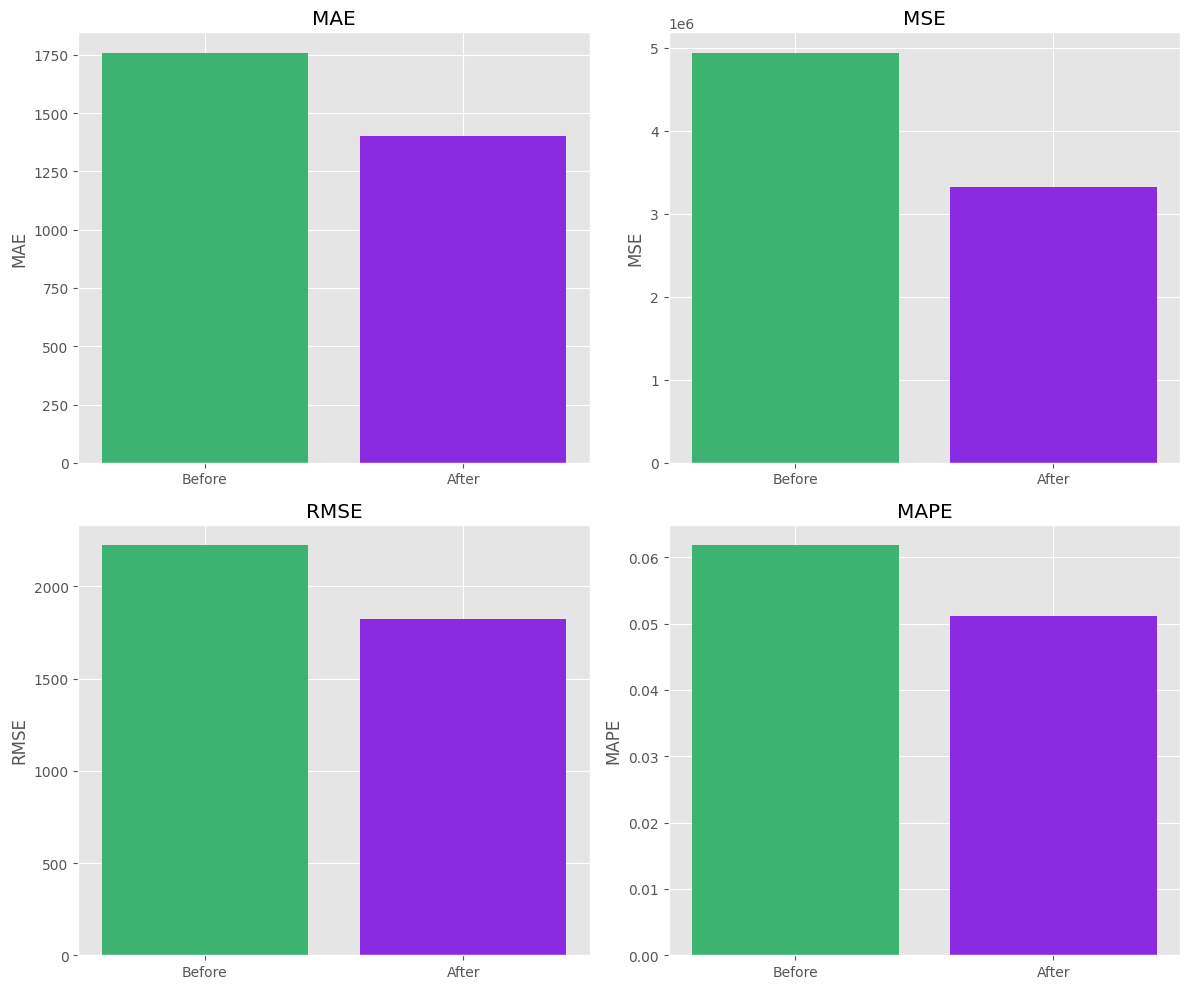

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define metric names and values before and after
metric_names = ['MAE', 'MSE', 'RMSE', 'MAPE']
metrics_after = [1402.4187, 3326944.3727, 1823.9913, 0.0512]
metrics_before = [1758.9160, 4938389.9006, 2222.2488, 0.0618]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# Plot each metric
for i, metric_name in enumerate(metric_names):
    ax = axs[i]
    ax.bar(['Before', 'After'], [metrics_before[i], metrics_after[i]], color=['mediumseagreen', 'blueviolet'])
    ax.set_title(metric_name)
    ax.set_ylabel(metric_name)

plt.tight_layout()
plt.show()


ValueError: Plot Not Available. Please see docstring for list of available Plots.

# Zone 2 and zone 3

In [ ]:
train = df.iloc[:int(len(df) * 0.85)]
valid = df.iloc[int(len(df) * 0.85):]

print(f"Train set length: {len(train)}")
print(f"Validation set length: {len(valid)}")

Train set length: 44553
Validation set length: 7863


In [ ]:
traintest2 = train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','hour','month', 'Zone 2  Power Consumption']]
valid2 = valid[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','hour','month', 'Zone 2  Power Consumption']]

traintest3 = train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','hour','month', 'Zone 3  Power Consumption']]
valid3 = valid[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','hour','month', 'Zone 3  Power Consumption']]

In [ ]:
s2 = setup(data = traintest2, test_data = valid2,
          target='Zone 2 Power Consumption',
          preprocess = True,
          fold_strategy='timeseries',
          fold_shuffle=False,
          data_split_shuffle=False)

In [ ]:
model_name = "et"
extra_model2 = create_model(model_name)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1420.3338,3611496.8071,1900.3939,0.8143,0.1065,0.0813
1,1364.2860,3381084.0081,1838.7724,0.8135,0.1001,0.0771
2,2025.9050,6955709.5034,2637.3679,0.5162,0.1442,0.1203
3,2138.9913,6090440.5591,2467.8818,0.6221,0.1306,0.1089
4,2605.6068,12002341.7647,3464.4396,0.3824,0.1828,0.1296
5,2368.1330,8898988.0850,2983.1172,0.5865,0.1402,0.1103
6,2805.6653,11552600.6740,3398.9117,0.5443,0.1331,0.1046
7,3300.1371,16934412.2063,4115.1443,0.3451,0.1862,0.1658
8,3153.2515,14899710.1079,3860.0143,0.1580,0.1941,0.1464


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import plotly.express as px

predictions_zone2 = predict_model(extra_model2, data=valid2)

fig = px.line(predictions_zone2, x=predictions_zone2.index, y=["Zone 2 Power Consumption", "prediction_label"], color_discrete_sequence=['blue', 'orange'])
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1549.9796,3815324.4134,1953.2855,0.8778,0.0877,0.0681


In [ ]:
s3 = setup(data = traintest3 , test_data = valid3,
          target='Zone 3 Power Consumption',
          preprocess = True,
          fold_strategy='timeseries',
          fold_shuffle=False,
          data_split_shuffle=False)

,Description,Value
0,Session id,1101
1,Target,Zone 3 Power Consumption
2,Target type,Regression
3,Original data shape,"(52416, 8)"
4,Transformed data shape,"(52416, 8)"
5,Transformed train set shape,"(44553, 8)"
6,Transformed test set shape,"(7863, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [ ]:
model_name = "et"
extra_model3 = create_model(model_name)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,774.5533,1167669.1547,1080.5874,0.9387,0.0650,0.0477
1,738.3166,1148623.6159,1071.7386,0.9373,0.0672,0.0470
2,1675.8935,3826921.3868,1956.2519,0.8157,0.1107,0.0908
3,1151.6289,2154070.5275,1467.6752,0.8782,0.0832,0.0679
4,2279.8477,10449714.2351,3232.6018,0.6116,0.1674,0.1124
5,5224.2878,40778955.6300,6385.8402,0.0093,0.2902,0.2055
6,2565.5675,10388900.3990,3223.1817,0.7752,0.1129,0.0882
7,5482.2671,49607014.4383,7043.2247,-0.1838,0.3245,0.3171
8,2693.6357,10039398.1872,3168.5009,0.0161,0.2064,0.2001


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import plotly.express as px

predictions_zone3 = predict_model(extra_model3, data=valid3)

fig = px.line(predictions_zone3, x=predictions_zone3.index, y=["Zone 3 Power Consumption", "prediction_label"], color_discrete_sequence=['blue', 'orange'])
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1484.3660,3919511.7616,1979.7757,0.6527,0.1584,0.1249
